In [1]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy

 If you are on SWAN and did not expect this warning, then restart and load the 'NXCals Pro' software stack.
No pytransport functionality
No pytransport functionality


In [2]:
import ROOT

Welcome to JupyROOT 6.28/06


In [3]:
class SimpleADT(xt.BeamElement):
    _xofields = {
        "angular_kick": xo.Float64,
        "seed": xo.Int64,
        "set_seed": xo.Int64,
        "plane": xo.Int64,
    }

    isthick = False
    behaves_like_drift = False

    _extra_c_sources = [
        '''
        #ifndef XTRACK_SIMPLEADT_H
        #define XTRACK_SIMPLEADT_H

        #include <math.h>
        #include <string.h>
        #include <stdio.h>
        #include <stdlib.h>
        #include <time.h>

        /*gpufun*/
        void SimpleADT_track_local_particle(SimpleADTData el, LocalParticle* part0){
            

            float angular_kick = SimpleADTData_get_angular_kick(el);
            int seed = SimpleADTData_get_seed(el);
            int set_seed = SimpleADTData_get_set_seed(el);
            //char* plane = SimpleADTData_getp_plane(el);
            int plane = SimpleADTData_get_plane(el);
            
            if(set_seed!=0){
                srand(seed);
            }else{
                srand(time(NULL));
            }
                    
            
            //start_per_particle_block (part0->part)
                /*
                if(strcmp(plane, "H") == 0){
                    float px = LocalParticle_get_px(part);
                    float kick = ((float)rand() / RAND_MAX) * 2*angular_kick - angular_kick;
                    LocalParticle_set_px(part, px + kick);
                }else if(strcmp(plane, "V") == 0){
                    float py = LocalParticle_get_py(part);
                    float kick = ((float)rand() / RAND_MAX) * 2*angular_kick - angular_kick;
                    LocalParticle_set_py(part, py + kick);    
                }
                */
                
                
                if(plane==0){
                    float px = LocalParticle_get_px(part);
                    float kick = ((float)rand() / RAND_MAX) * 2*angular_kick - angular_kick;
                    LocalParticle_set_px(part, px + kick);
                }else if(plane==1){
                    float py = LocalParticle_get_py(part);
                    float kick = ((float)rand() / RAND_MAX) * 2*angular_kick - angular_kick;
                    LocalParticle_set_py(part, py + kick); 
                }
                
            //end_per_particle_block
        }

        #endif /* XTRACK_SIMPLEADT_H */
        '''
    ]

    def __init__(self,  angular_kick = 10e-9,
                        seed = 1234,
                        set_seed = 1,
                        plane = 'V',
                       **kwargs):
        
        if plane == 'H':
            plane_int = 0
        elif plane == 'V':
            plane_int = 1
        else: 
            print('Error!! Insert "V" or "H" as plane')
            
        if '_xobject' not in kwargs:
            kwargs.setdefault('angular_kick', angular_kick)
            kwargs.setdefault('seed', seed)
            kwargs.setdefault('set_seed', set_seed)
            kwargs.setdefault('plane', plane_int)

        super().__init__(**kwargs)

    has_backtrack = False


In [4]:
adt = SimpleADT(angular_kick = 50e-6, plane='V')
p0c_ft = 6.8e12
drift_length = 200
drift =  xt.Drift(length=drift_length)

line = xt.Line(elements=[adt, drift], element_names=["TCCS", "drift"])
line.build_tracker(_context=xo.ContextCpu(omp_num_threads=6))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [5]:
def plot(x, y, px, py, tit=''):
    fig1 = plt.figure(figsize=(22, 10))
    ax1 = fig1.add_subplot(2,3,1)
    ax1.hist(x, bins=100)
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel("")
    ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])

    ax2 = fig1.add_subplot(2,3,2)
    ax2.hist(y, bins=100) 
    ax2.set_xlabel('y [mm]')
    ax2.set_ylabel('')

    ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])

    ax3 = fig1.add_subplot(2,3,3)
    h = ax3.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
    ax3.set_xlabel(r'x [mm]')
    #ax3.set_ylim(0,0.008)
    ax3.set_ylabel(r'y [mm]')
    ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
    ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])

    axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )
    fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
    ax3.grid(linestyle=':')

    ax12 = fig1.add_subplot(2,3,4)
    ax12.hist(px, bins=100)
    ax12.set_xlabel(r'px [$\mu$rad]')
    ax12.set_ylabel("")   
    ax12.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])


    ax22 = fig1.add_subplot(2,3,5)
    ax22.hist(py, bins=100) 
    ax22.set_xlabel(r'py [$\mu$rad]')
    ax22.set_ylabel('')
    ax22.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])

    ax32 = fig1.add_subplot(2,3,6)
    h2 = ax32.hist2d(px, py, bins=100, norm=matplotlib.colors.LogNorm())  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
    ax32.set_xlabel(r'px [$\mu$rad]')
    ax32.set_ylabel(r'py [$\mu$rad]')
    ax32.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
    ax32.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.yticks()[0]])
    axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
    fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
    ax32.grid(linestyle=':')
    
    fig1.suptitle(tit)
        

In [6]:
n_part = 10000000

x = np.random.uniform(-0.001, 0.001, n_part)
px = np.zeros(n_part)
y = np.random.uniform(0.0, 0.002, n_part)
py = np.random.normal(0.0, 1e-6, n_part)

part = xp.Particles(x=x, 
                    px=px, 
                    y=y, 
                    py=py, 
                    p0c=p0c_ft)

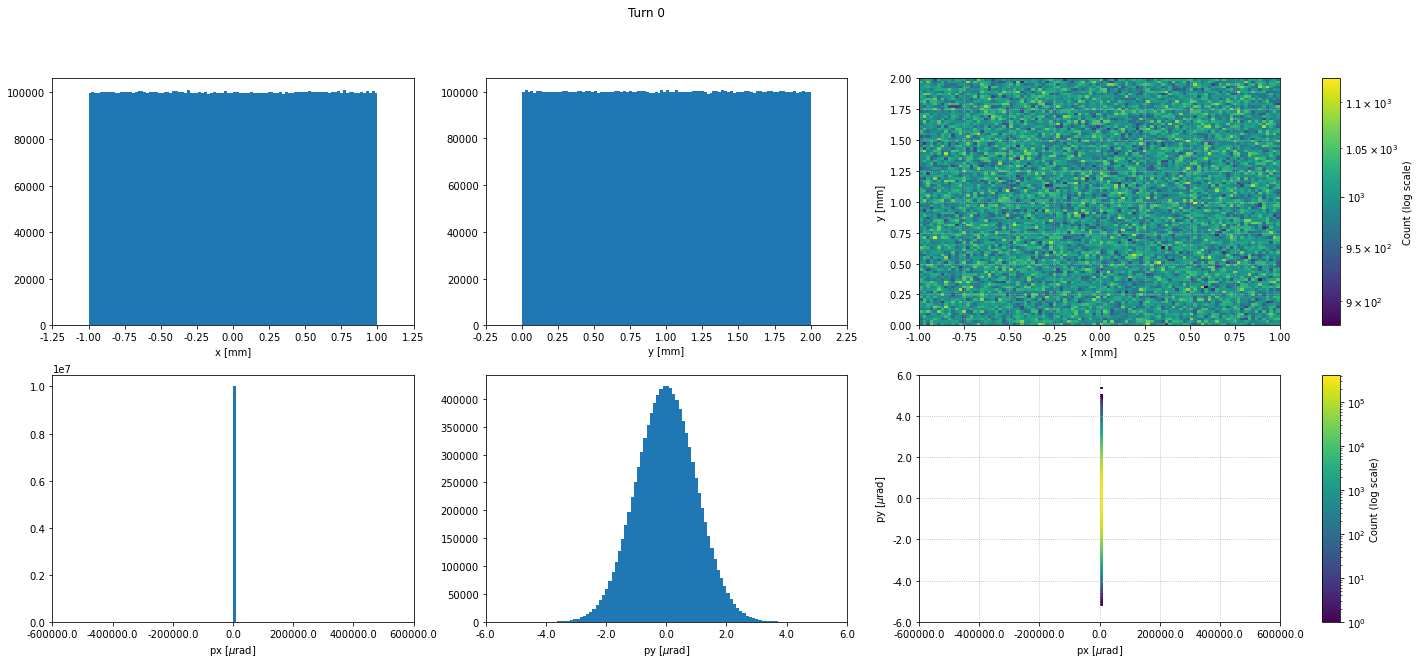

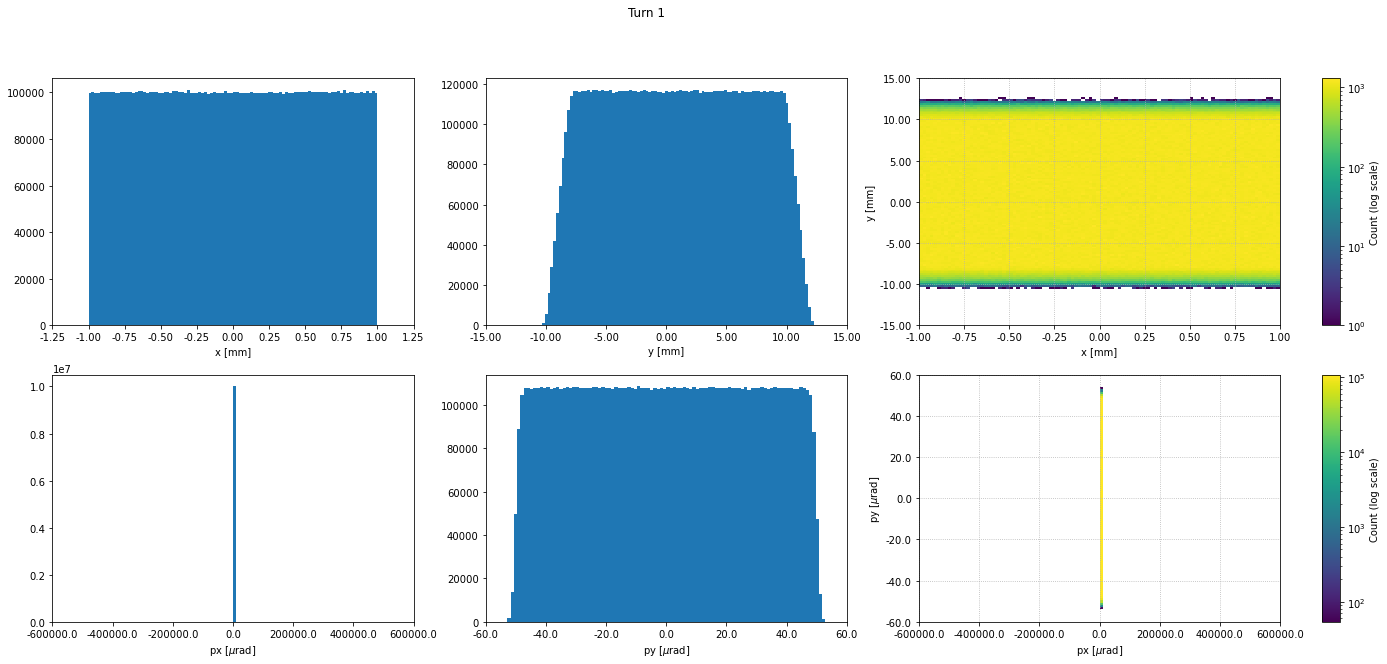

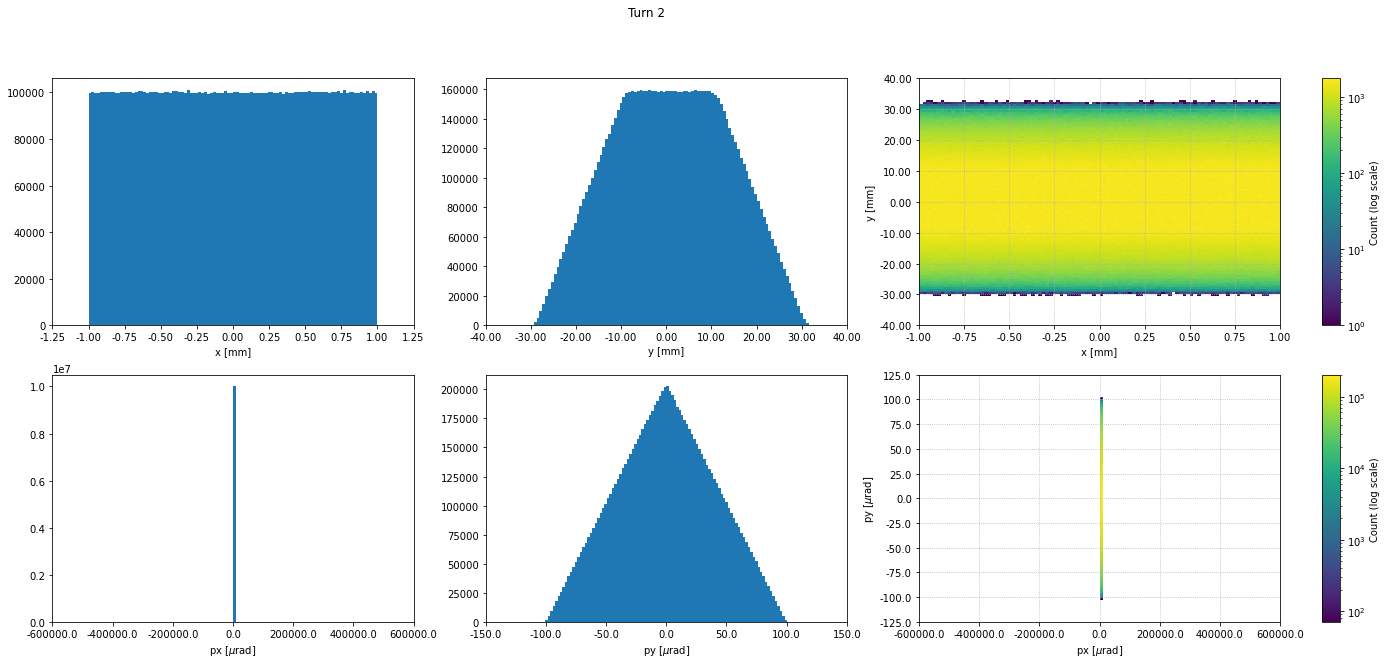

In [7]:
plot(part.x, part.y, part.px, part.py, tit="Turn 0")
line.track(part, num_turns=1)
plot(part.x, part.y, part.px, part.py, tit="Turn 1")
line.track(part, num_turns=1)
plot(part.x, part.y, part.px, part.py, tit="Turn 2")

## Backup

In [ ]:
def generate_adt_time_profile(settings, gain_ramp_time = None, rampdown_final_level = None, gain_ramp_start_level = None):
    """Generate an ADT time profile for the quench test. 
    Later rename to adt white_noiser
    gain_ramp_time        : number of seconds until the maximum should be reached
    rampdown_final_level  : level between zero and one where we want to stop the adt time profile   
    """

    nturns   = settings['simulation']['nturns']

    if gain_ramp_start_level is None:
        try:
            gain_ramp_start_level       = settings['pulsing_pattern']['ramp_adt']['gain_ramp_start_level']
            gain_ramp_start_level       = float(gain_ramp_start_level)
        except:
            # backwards compatibility
            pf('generate_adt_time_profile', 'WARNING: Did not find gain_ramp_start_level in settings file')
            pf('generate_adt_time_profile', '         Setting gain_ramp_start_level to zero')


    if gain_ramp_time is None:
        gain_ramp_time       = settings['pulsing_pattern']['ramp_adt']['gain_ramp_time']
        gain_ramp_time       = int(gain_ramp_time)

    if rampdown_final_level is None:
        rampdown_final_level = settings['pulsing_pattern']['ramp_adt']['rampdown_final_level']
        rampdown_final_level = float(rampdown_final_level)

    try: 
        if settings['pulsing_pattern']['ramp_adt']['from_file'] is False: 
            from_file = False
        else:
            from_file = settings['pulsing_pattern']['ramp_adt']['from_file']
    except:
        from_file=False

    # sample the white noise from the ADT (values between 0 and 1)
    adt_kick = (np.random.uniform(low=0.0, high=1.0, size=nturns)-0.5)/0.5

    if not from_file:
        
        turns_per_second = 11245

        turns_to_peak      = turns_per_second*gain_ramp_time

        ramp_to_peak       = np.linspace(gain_ramp_start_level,1,turns_to_peak)

        rampdown_from_peak = np.linspace(1,rampdown_final_level, max(1,nturns - turns_to_peak))

        gain_ramp = np.append(ramp_to_peak, rampdown_from_peak)

    else: 
        # if we read from file 
        gain_ramp = pd.read_csv(from_file, names=['modulation'])
        gain_ramp = np.array(gain_ramp['modulation'])

    # if we want to start after a couple of turns 
    try:
        if int(settings['pulsing_pattern']['ramp_adt']['start'])>0:
            start_zeros = np.zeros(settings['pulsing_pattern']['ramp_adt']['start'])
            gain_ramp   = np.append(start_zeros, gain_ramp)
    except KeyError:
        pass

    # to match the lengths 
    gain_ramp = gain_ramp[:len(adt_kick)]

    df = pd.DataFrame(adt_kick*gain_ramp, columns=['adt_kick'])
    df.to_string("adt_kicks_per_turn.dat")

    return adt_kick*gain_ramp

In [ ]:
def element_properties(name):
    _idx = sequence.element_names.index(name)
    return sequence.elements[_idx].to_dict()

sys.path.append("/afs/cern.ch/user/p/pahermes/public/simcontrol/templates/xtrack/")
sys.path.append("/afs/cern.ch/user/p/pahermes/public/simcontrol/python_scripts/")

import xtrack_tools as xtt

# ## Load settings and inputs
# load the settings file 
settings = xtt.load_settings()



## ADT WHITE NOISE TIME PROFILE 

# generate pulsing pattern 
# adt_kick = (np.random.uniform(low=0.0, high=1.0, size=settings['simulation']['nturns'])-0.5)/0.5

gain_ramp_time       = settings['pulsing_pattern']['ramp_adt']['gain_ramp_time']
gain_ramp_time       = int(gain_ramp_time)

rampdown_final_level = settings['pulsing_pattern']['ramp_adt']['rampdown_final_level']
rampdown_final_level = float(rampdown_final_level)

adt_kick             = xtt.generate_adt_time_profile(settings, gain_ramp_time, rampdown_final_level)





# get the to_np function depending on the context 
to_np    = xtt.get_to_np(settings)

# load sequence
sequence = xtt.sequence.load_sequence(settings)



# set cavity properties 
for cav in sequence.get_elements_of_type(xt.Cavity)[1]:
    idx = sequence.element_names.index(cav)   
    sequence.elements[idx].voltage   = 1500000.0
    sequence.elements[idx].frequency = 400789598.98582596
    sequence.elements[idx].lag       = 180.0

# # get twiss parameters
tw        = xtt.get_twiss(settings, sequence.copy())

# settings['initial']['filename'] = "/afs/cern.ch/work/p/pahermes/private/401_quenchtest22/000_initial_dist/initial.dgauss.run3.dat"

# read initial distribution 
part      = xtt.read_initial_distribution(settings)

# set the elements to their reference values 
# apply settings specified in "set_elements"
xtt.set_element_value(sequence, settings)

# COLLIMATION part 
# use the beta-functions to get the collimator settings 
cc       = xtt.collimation(settings, tw)
settings = cc.add_collimator_settings()

# add the upstream and downstream markers for the collimators
cc.install_all_collimator_markers(sequence, settings)

## now set the collimators to their gaps 
cc.apply_collimator_settings(sequence, settings)

# get the reference settings for all elements of the sequence that can be pulsed
xtt.add_all_reference_settings(sequence, settings)

xtt.save_tracked_sequence(sequence)


# # Prepare tracking 
## Transfer lattice on context and compile tracking code
tracker = xt.Tracker(_context = settings['context_xo'], line = sequence)

# get ready for the initial distribution 
with open("dist0.json", 'r') as fid:
    part= xp.Particles.from_dict(json.load(fid), _context=settings['context_xo'])

survival  = xtt.survival(settings)
emittance = xtt.emittance(settings)
dump      = xtt.dump(settings)


turn_start = settings['simulation']['turn_start']
turn_end   = settings['simulation']['turn_start'] + settings['simulation']['nturns']


# dump the starting conditions 
dump.dump_turn(part, turn_start-1, to_np)

# perform the turn-by-turn tracking 
for turn in range(1,settings['simulation']['nturns']+1):
    
    _turn_idx = turn-1
    
    if turn % 10 == 0:
        print("Tracking turn: {0}".format(turn))
    # apply the pulsing pattern 
    xtt.apply_pulsing(tracker.line, settings, adt_kick, turn)
    
    tracker.track(part, num_turns=1)
    
    survival.get_surviving_particles(turn, part)
    emittance.get_emittance(turn, part)
    dump.dump_turn(part, turn, to_np)

survival.write_survival()
emittance.write_emittance_table()
xtt.collimation.write_coll_summary(part, sequence, settings)

dump.write_dumpfile()

# save the initial distribution 
with open('final_dist.json', 'w') as fid:
    json.dump(part.to_dict(), fid, cls=xo.JEncoder)

xtt.save_settings(settings)

In [ ]:
def apply_pulsing(line, settings, pattern, turn, values_key='reference_values'):
    
    """
        values_key: name of the block in the settings file that should be used for the pulsing - useful in case multiple pulsing mechanisms should be used in parallel
    """
    
    # if pulsing is not activated 
    if settings['pulsing_pattern']['activate'] is False:
        return 


    pref     = settings['pulsing_pattern'][values_key]
    idx_turn = turn - 1                                            
    on_off   = pattern[idx_turn]                                   # state of the pulsing (on/off)
    
    for name in pref.keys():
        
        for attr in pref[name].keys():

            _val = pref[name][attr]

            if (type(_val) is list) or (type(_val) is np.ndarray):
                
                if settings['context']=='GPU':

                    import cupy 
                    _val = [float(v)*on_off for v in _val]
                    _val = cupy.array(_val)
                    setattr(line.element_dict[name], attr, _val)

                    pf("apply_pulsing", "Turn {0} : applying pulsing {1}, {2}, {3}".format(turn, name,  attr, [float(v)*on_off for v in _val]), settings)

                else:
                    setattr(line.element_dict[name], attr, [float(v)*on_off for v in _val])
                    
                    pf("apply_pulsing", "Turn {0} : applying pulsing {1}, {2}, {3}".format(turn, name,  attr, [float(v)*on_off for v in _val]), settings)
            else:
                setattr(line.element_dict[name], attr, _val*on_off)

                pf("apply_pulsing", "Turn {0} : applying pulsing {1}, {2}, {3}".format(turn, name,  attr, _val*on_off), settings)
